# 15_BANKSY_style_SIMBA_rankK

In [1]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(1, '../scripts/benchmarking')

In [2]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
import os
import simba as si
si.__version__

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [4]:
workdir = 'data/15'
si.settings.set_workdir(workdir)

Saving results in: data/15


In [5]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [6]:
import anndata as ad
from scipy.sparse import csr_matrix
# from manually added path
from spatial import gen_spatial_graph
from plot import plot_spatial_kernel
import squidpy as sq

# Load data

In [7]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

In [8]:
from scipy.spatial import cKDTree

# Build the KDTree
coords = adata.obsm['spatial']
tree = cKDTree(coords)

# Query the k+1 nearest neighbors (to exclude the point itself)
k = 6
distances, indices = tree.query(coords, k=k+1)
# Exclude self (first column)
indices = indices[:, 1:]

print(indices)

[[3165 1084 1337 2804 4039 3710]
 [1202 4110  453 2429 2687  549]
 [3334 1706  786 2509 2694 1853]
 ...
 [3352 2148 3810   75  352  953]
 [ 660 3281 3046 2077 3970 2255]
 [1798 2660 3960  131 2478 2906]]


In [9]:
indices.shape

(4221, 6)

In [10]:
rankK_adatas = {}
for rank in range(k):
    k_adata = adata.copy()
    k_adata.X = adata.X[indices[:, rank], :]
    k_adata.var_names = k_adata.var_names + "_r" + str(rank)
    rankK_adatas[rank] = k_adata.copy()

In [11]:
def combine_adatas(adata_CG, K_adata_CG, lambda_val=0.8):
    
    num_neighbors = len(K_adata_CG)
    kn_weight = np.sqrt(1 - lambda_val) / num_neighbors # uniform weight on the neighbors

    tmp_adata_CG = adata_CG.copy()
    tmp_adata_CG.X = tmp_adata_CG.X * lambda_val
    tmp_adata_CG.var['gene_rank'] = -1
    weighted_adatas = [tmp_adata_CG]

    for r, adata in K_adata_CG.items():
        tmp_adata = adata.copy()
        tmp_adata.X = tmp_adata.X * kn_weight
        tmp_adata.var['gene_rank'] = r
        weighted_adatas.append(tmp_adata)

    banksy_adata = ad.concat(weighted_adatas, axis=1)
    banksy_adata.layers['counts'] = csr_matrix(banksy_adata.X)
    return banksy_adata, lambda_val, kn_weight

In [12]:
len(rankK_adatas)

6

In [13]:
banksy_local_adata, lambda_val, kn_weight = combine_adatas(adata, rankK_adatas, lambda_val=0.8)

In [14]:
kn_weight

0.07453559924999298

In [15]:
banksy_local_adata.shape

(4221, 110726)

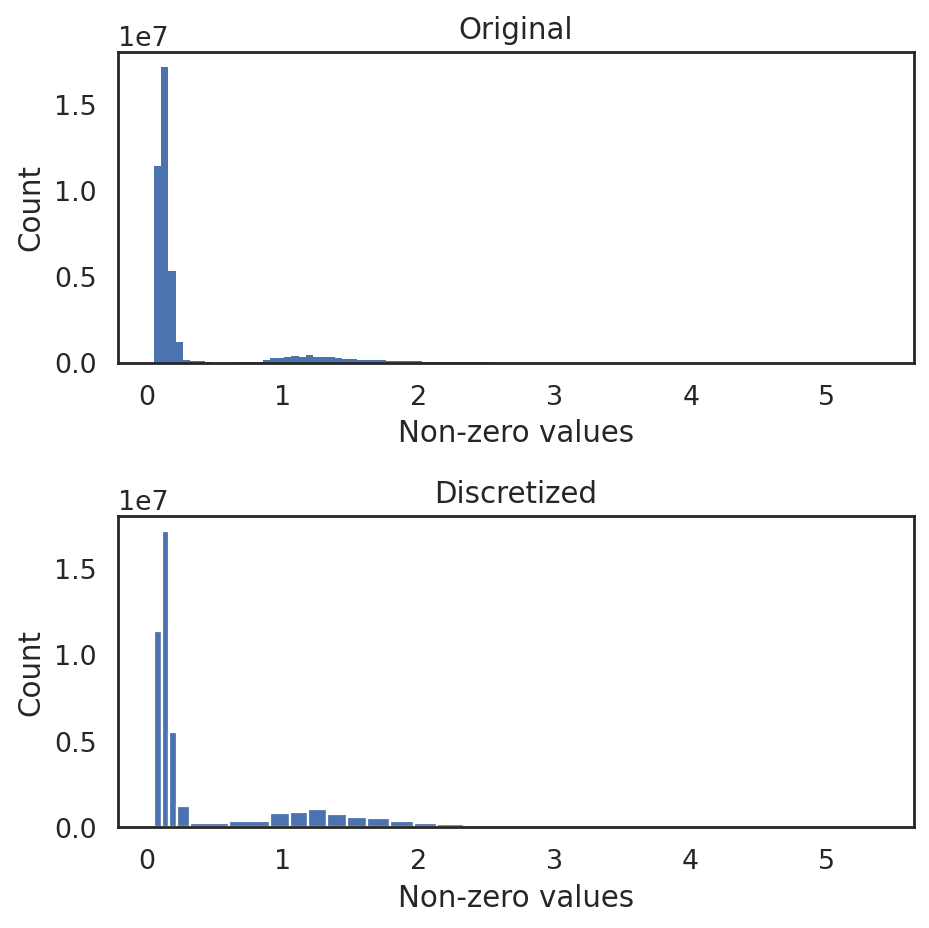

In [16]:
si.tl.discretize(banksy_local_adata,n_bins=20)
si.pl.discretize(banksy_local_adata,kde=False)

In [17]:
banksy_local_adata.var.gene_rank.value_counts()

gene_rank
-1    15818
 0    15818
 1    15818
 2    15818
 3    15818
 4    15818
 5    15818
Name: count, dtype: int64

In [18]:
si.tl.gen_graph(
    list_CG=[banksy_local_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_local_k6'
)

relation0: source: C, destination: G
#edges: 11411720
relation1: source: C, destination: G
#edges: 17210149
relation2: source: C, destination: G
#edges: 5499052
relation3: source: C, destination: G
#edges: 1229488
relation4: source: C, destination: G
#edges: 245536
relation5: source: C, destination: G
#edges: 333904
relation6: source: C, destination: G
#edges: 787658
relation7: source: C, destination: G
#edges: 889186
relation8: source: C, destination: G
#edges: 1016481
relation9: source: C, destination: G
#edges: 781546
relation10: source: C, destination: G
#edges: 577204
relation11: source: C, destination: G
#edges: 515522
relation12: source: C, destination: G
#edges: 363195
relation13: source: C, destination: G
#edges: 239201
relation14: source: C, destination: G
#edges: 172056
relation15: source: C, destination: G
#edges: 110410
relation16: source: C, destination: G
#edges: 68247
relation17: source: C, destination: G
#edges: 34213
relation18: source: C, destination: G
#edges: 17577

In [19]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_local_k6')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000853
Weight decay being used for training is 0.000853
Converting input data ...
[2025-03-11 14:37:30.664930] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-03-11 14:37:30.665537] These files are in: data/15/pbg/graph_local_k6/input/entity, data/15/pbg/graph_local_k6/input/edge
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/util.py:211: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_type = dummy_tensor.storage_type()
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/checkpoint_manager.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

Finished


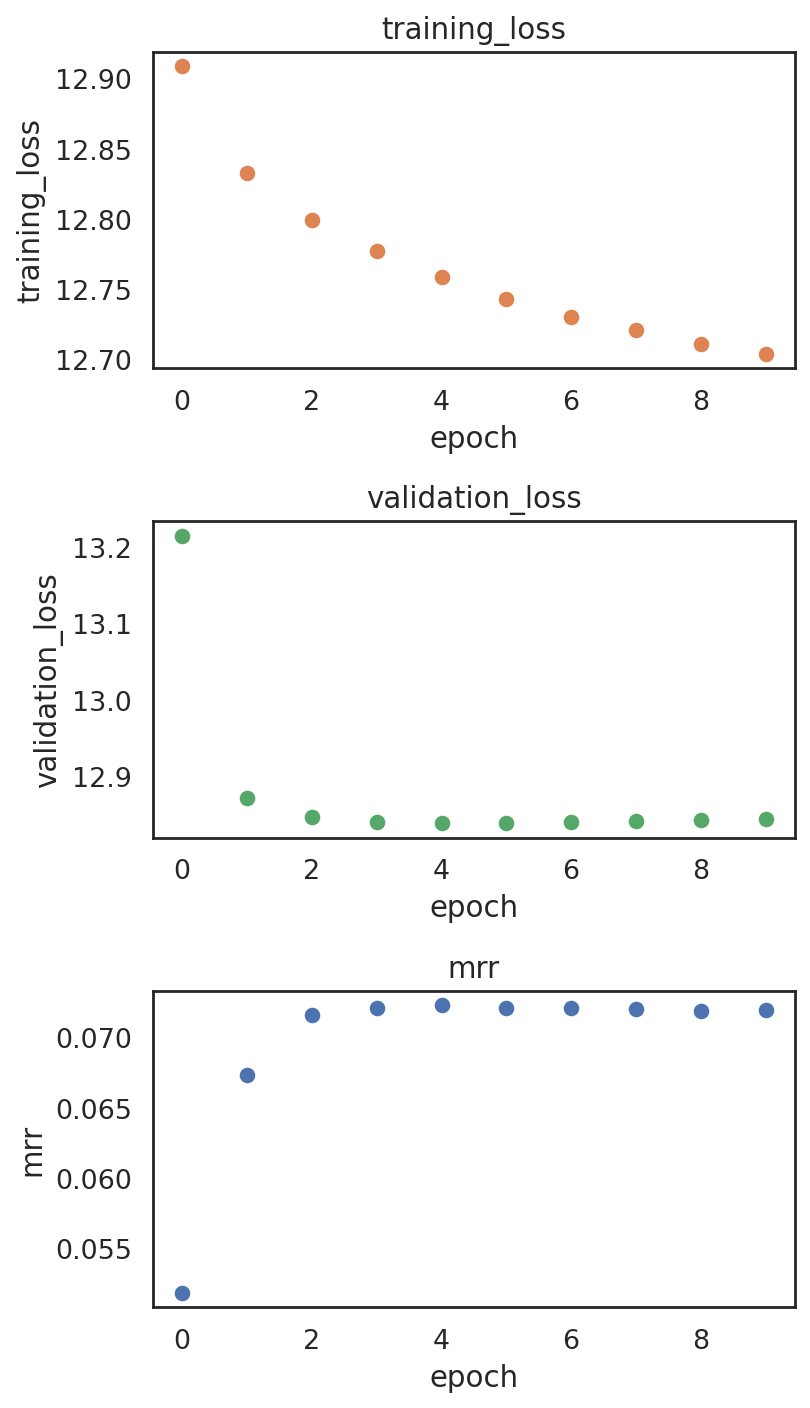

In [20]:
si.pl.pbg_metrics(fig_ncol=1)

In [21]:
# read in entity embeddings obtained from pbg training.
local_dict_adata = si.read_embedding()
local_dict_adata

{'G': AnnData object with n_obs × n_vars = 110726 × 50,
 'C': AnnData object with n_obs × n_vars = 4221 × 50}

In [22]:
local_adata_C = local_dict_adata['C']  # embeddings of cells
local_adata_G = local_dict_adata['G']  # embeddings of cells
local_adata_C.obs['spatialLIBD'] = adata[local_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
local_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

In [23]:
from cluster import get_pairwise_distance
from sklearn.metrics import silhouette_score

In [24]:
dists = get_pairwise_distance(local_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=local_adata_C.obs['spatialLIBD'])
sil

0.012356297

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


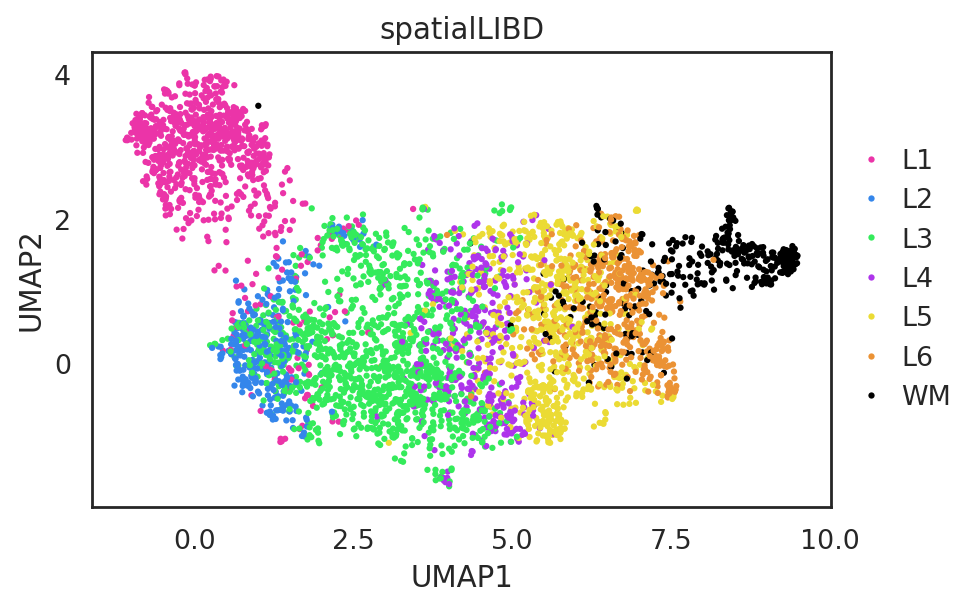

In [25]:
si.tl.umap(local_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    local_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Global

In [26]:
banksy_global_adata, lambda_val, kn_weight = combine_adatas(adata, rankK_adatas, lambda_val=0.2)
kn_weight

0.14907119849998599

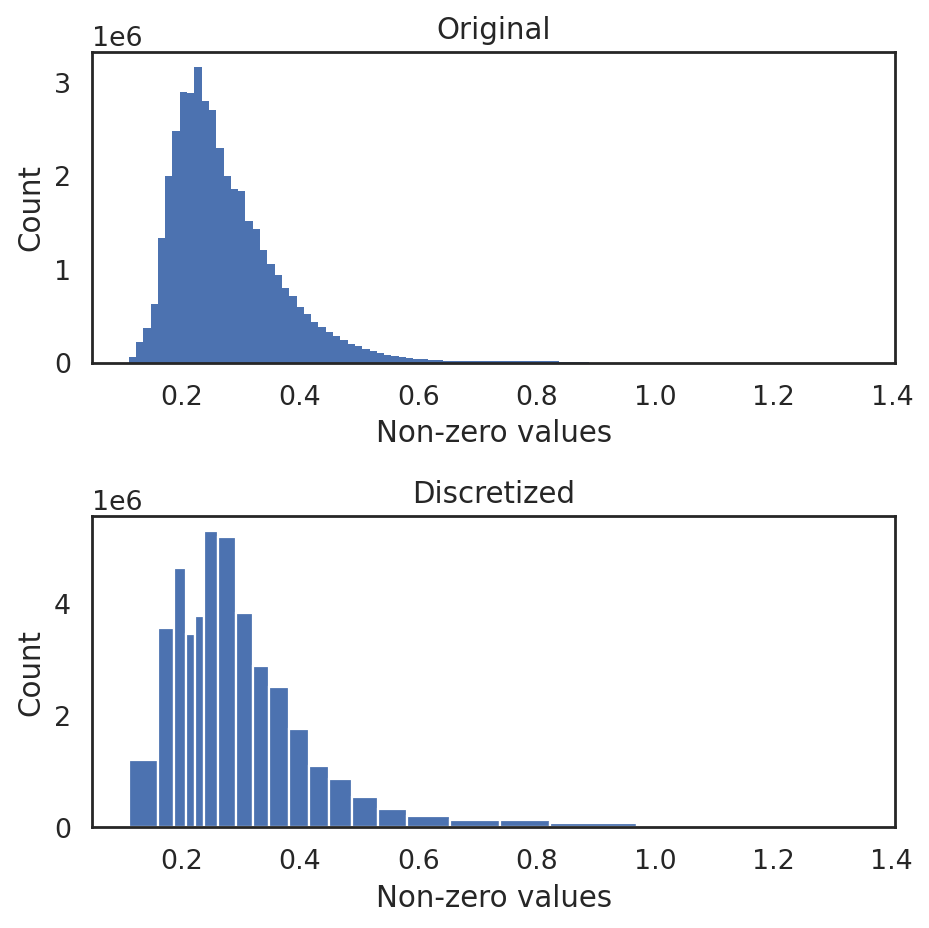

In [27]:
si.tl.discretize(banksy_global_adata,n_bins=20)
si.pl.discretize(banksy_global_adata,kde=False)

In [29]:
si.tl.gen_graph(
    list_CG=[banksy_global_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_global_k6'
)

relation0: source: C, destination: G
#edges: 1191728
relation1: source: C, destination: G
#edges: 3566292
relation2: source: C, destination: G
#edges: 4643366
relation3: source: C, destination: G
#edges: 3465424
relation4: source: C, destination: G
#edges: 3783736
relation5: source: C, destination: G
#edges: 5309654
relation6: source: C, destination: G
#edges: 5199606
relation7: source: C, destination: G
#edges: 3827861
relation8: source: C, destination: G
#edges: 2883155
relation9: source: C, destination: G
#edges: 2510087
relation10: source: C, destination: G
#edges: 1760461
relation11: source: C, destination: G
#edges: 1101435
relation12: source: C, destination: G
#edges: 862515
relation13: source: C, destination: G
#edges: 537435
relation14: source: C, destination: G
#edges: 322472
relation15: source: C, destination: G
#edges: 204244
relation16: source: C, destination: G
#edges: 132234
relation17: source: C, destination: G
#edges: 123258
relation18: source: C, destination: G
#edges

In [30]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_global_k6')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000853
Weight decay being used for training is 0.000853
Converting input data ...
[2025-03-11 14:54:49.464951] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-03-11 14:54:49.465376] These files are in: data/15/pbg/graph_global_k6/input/entity, data/15/pbg/graph_global_k6/input/edge
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/checkpoint_manager.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

Finished


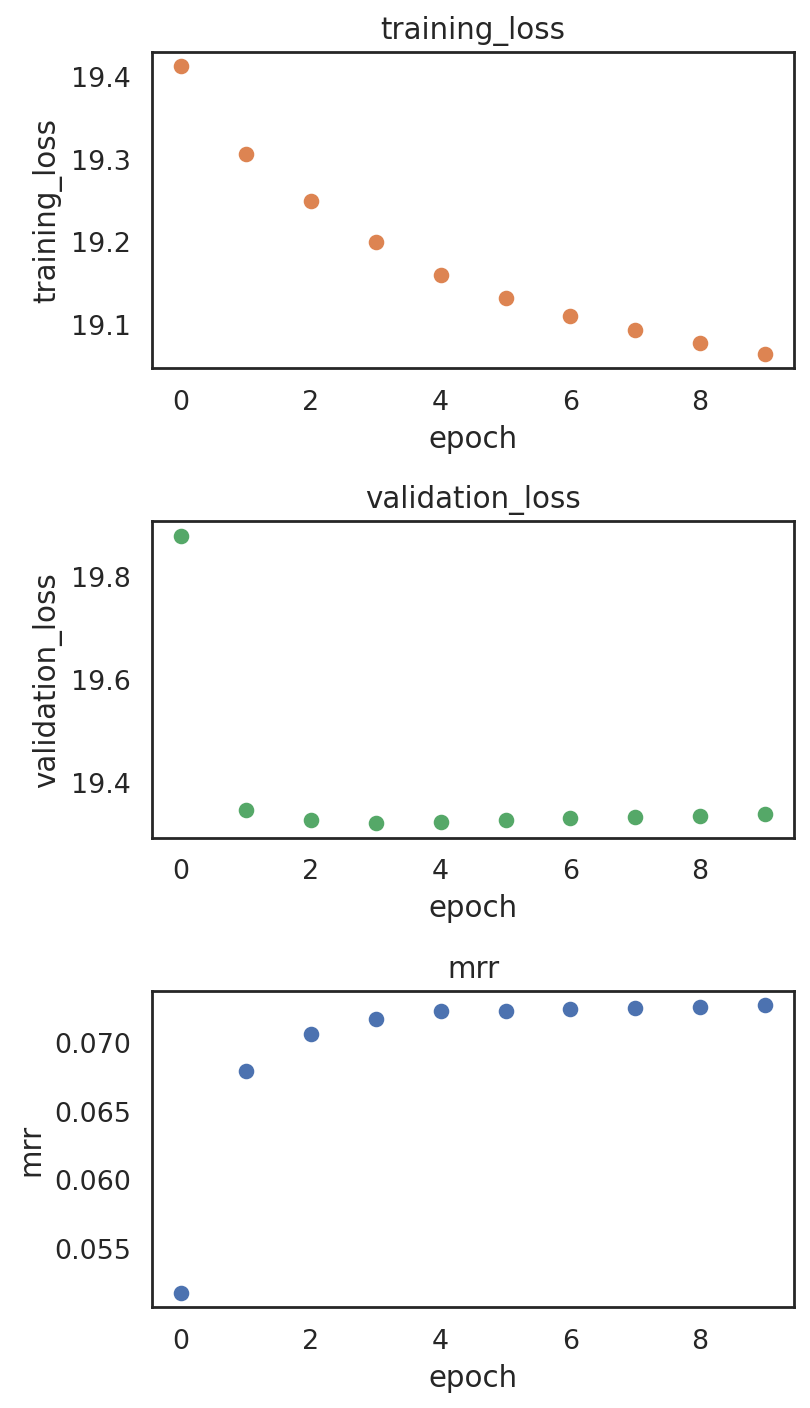

In [31]:
si.pl.pbg_metrics(fig_ncol=1)

In [32]:
# read in entity embeddings obtained from pbg training.
global_dict_adata = si.read_embedding()
global_dict_adata

{'G': AnnData object with n_obs × n_vars = 110726 × 50,
 'C': AnnData object with n_obs × n_vars = 4221 × 50}

In [33]:
global_adata_C = global_dict_adata['C']  # embeddings of cells
global_adata_G = global_dict_adata['G']  # embeddings of cells
global_adata_C.obs['spatialLIBD'] = adata[global_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
global_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


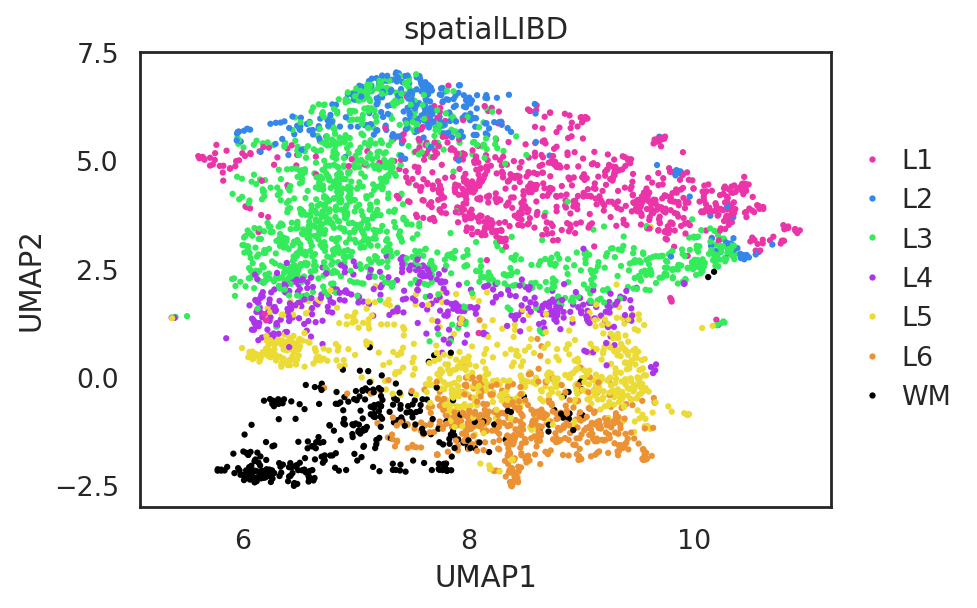

In [34]:
si.tl.umap(global_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    global_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [35]:
dists = get_pairwise_distance(global_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=global_adata_C.obs['spatialLIBD'])
sil

-0.029675713